# Comparison of spatial smoothing methods in AFNI

This notebook provides a simple walkthrough of several spatial smooothing methods in [AFNI](https://afni.nimh.nih.gov/) ([Cox et al., 1996](https://doi.org/10.1006/cbmr.1996.0014), [2012](https://doi.org/10.1016/j.neuroimage.2011.08.056)). The goal of this notebook is to compare the different methods and the resulting smoothness of the data after applying each method. We rely on Python's `subprocess` module to run command-line AFNI programs. This notebook requires an [AFNI installation](https://afni.nimh.nih.gov/pub/dist/doc/htmldoc/background_install/install_instructs/index.html) (also available via [NeuroDebian](http://neuro.debian.net/)), as well Python modules `numpy`, `nibabel`, and `nilearn` (we recommend installing these in a `conda` environment).

---
Author: Samuel A. Nastase

In [1]:
from os.path import exists
from subprocess import run, PIPE
import nibabel as nib
import numpy as np
from nilearn import image, plotting

## Volumetric smoothing
In this notebook, we evaluate both volumetric and surface-based methods for spatial smoothing. We begin by evaluating methods for volumetric smoothing; i.e., smoothing in 3D image space. Although volumetric analysis is considerably more common than surface-based analysis in the fMRI literature,  there is evidence suggesting that surface-based analysis is superior for smoothing and localization (see [surface-based smoothing](#Surface-based-smoothing) for more).

### Example volumetric data
As an example dataset, we use a volumetric functional run from the Narratives collection ([Nastase et al., 2019](https://doi.org/10.18112/openneuro.ds002345.v1.0.1)) preprocessed using [fMRIPrep](https://fmriprep.readthedocs.io/en/stable/) ([Esteban et al., 2019](https://doi.org/10.1038/s41592-018-0235-4)). The Narratives collection is available via OpenNeuro ([ds002345](https://openneuro.org/datasets/ds002345)) and [DataLad](http://datasets.datalad.org/?dir=/labs/hasson/narratives). This subject has been spatially normalized to the [ICBM 2009c Nonlinear Asymmetric](http://www.bic.mni.mcgill.ca/ServicesAtlases/ICBM152NLin2009) template in MNI space (`MNI152NLin2009cAsym`) and we use the accompanying whole-brain mask to constrain some smoothing methods (download [NIfTIs](http://www.bic.mni.mcgill.ca/~vfonov/icbm/2009/mni_icbm152_nlin_asym_09c_nifti.zip)). This notebook does not currently support smoothing evaluation across a large sample of subjects and should not be considered an authoritative statistical comparison of smoothing methods&mdash;results may vary across subjects, acquisition parameters, etc. 

In [2]:
# Pick a representative subject from Narratives
subject = 'sub-050'
task = 'pieman'
grid = '3.0mm'

# Filenames for the whole-brain MNI mask and resampled version
brain_fn = 'space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
mask_fn = f'space-MNI152NLin2009cAsym_desc-brain{grid}_mask.nii.gz'

# Filename for BOLD data
bold_fn = f'{subject}_task-{task}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

#### Downsampling the mask
We need to downsample the whole-brain mask (`2.0 x 2.0 x 2.0 mm` resolution) to the BOLD grid (in this case `3.0 x 3.0 x 4.0 mm` resolution) using AFNI's [`3dresample`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dresample.html). Let's look at the shape and resolution of our data to make sure everything makes sense.

In [3]:
# Resample the mask to match BOLD grid
if not exists(mask_fn):
    print("Resample brain mask to BOLD grid")
    run(f"3dresample -master {bold_fn} -prefix {mask_fn} "
        f"-input {brain_fn} -rmode NN", shell=True);

In [4]:
# Check the voxel dimensions of the BOLD image and mask
bold_shape = nib.load(bold_fn).shape[:3]
n_trs = nib.load(bold_fn).shape[-1]
print(f"BOLD shape: {bold_shape}")
print(f"Number of TRs: {n_trs}")
print(f"BOLD resolution: {nib.load(bold_fn).header.get_zooms()[:3]}")
print(f"mask resolution: {nib.load(mask_fn).header.get_zooms()[:3]}")

BOLD shape: (65, 77, 49)
Number of TRs: 300
BOLD resolution: (3.0, 3.0, 4.0)
mask resolution: (3.0, 3.0, 4.0)


### Evaluating the intrinsic smoothness of the data
We first estimate the empirical smoothness of the original data using AFNI's [`3dFWHMx`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dFWHMx.html). To be clear, we are *not* smoothing the data yet. This intrinsic smoothness estimate will serve as a baseline for comparison and depends on many features of the dataset (e.g., spatial resolution). We use the whole-brain mask to exclude non-brain voxels from the smoothness estimate (`-mask`) and detrend the time series data when estimating smoothness (`-detrend`). Note that [`3dFWHMx`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dFWHMx.html) is typically used to estimate the smoothness of noise for cluster-level inference (using the newer, more accurate `-acf`). Here we simply want to estimate the smoothness of the data in the classic way (`-ShowMeClassicFWHM`; [Forman et al., 1995](https://doi.org/10.1002/mrm.1910330508)). This returns the FWHM (full width at half maximum) smoothness (in mm) in the *x*, *y*, and *z* dimensions, as well as the combined smoothness across all three dimensions. These values are the geometric mean of volume-wise smoothness estimates across all volumes in the entire time series. For this example dataset, the intrinsic smoothness is 3.309 mm FWHM.

In [5]:
# Estimate FWHM from the original data
orig_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {bold_fn} "
                "-detrend -acf NULL -ShowMeClassicFWHM",
                shell=True, stdout=PIPE)
print("FWHM (no smoothing):", orig_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (no smoothing):  2.9519  3.21721  3.81454     3.30883


#### Visualizing smoothness
We can also visualize the smoothness of the data by plotting a given volume using `nilearn`'s `plot_epi` function. Here we plot three arbitrary slices for the middle TR in the time series.

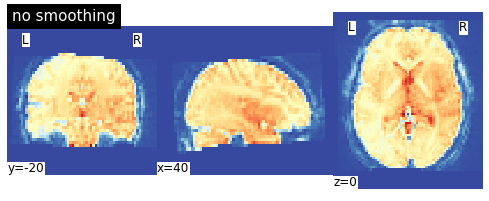

In [6]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(bold_fn, t),
                  cut_coords=coords, title='no smoothing',
                  cmap="RdYlBu_r", black_bg=False,
                  draw_cross=False, annotate='False');

### Smoothing with `3dmerge`
AFNI's [`3dmerge`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dmerge.html) has a wide range of functionality. Here we use it to spatially smooth the data with a 4.0 mm FWHM Gaussian kernel (`-1blur_fwhm 4.0`) and apply this smoothing kernel to all time points (`-doall`). This approach introduces a uniform amount of smoothness into the image; both smooth and non-smooth regions of the image will become smoother. The resulting smoothness of the image will be greater than the width of the smoothing kernel due to the pre-exising, intrinsic smoothness of the image (see . Note that `3dmerge` does not take a mask argument and smoothes the entire image (potentially mixing brain and non-brain values). Note, however, that the resulting smoothness of the image will be greater than the width of the smoothing kernel due to the pre-exising, intrinsic smoothness of the image (see [evaluating the intrinsic smoothness of the data](#Evaluating-the-intrinsic-smoothness-of-the-data)).

In [7]:
# Try 3dmerge classic smoothing (with no mask)
width = 4.0
merge_fn = (f'{subject}_task-{task}_space-MNI152NLin2009cAsym'
            f'_desc-3dmerge{width}_bold.nii.gz')

run(f"3dmerge -1blur_fwhm {width} -doall "
    f"-prefix {merge_fn} {bold_fn}", shell=True);

#### Evaluating smoothness after `3dmerge`
We use `3dFWHMx` to assess the resulting smoothness of the data after applying `3dmerge` and visualize the smoothness. For this example dataset, applying a 4.0 mm FWHM Gaussian kernel wiith `3dmerge` results in a smoothness of 5.919 mm FWHM.

In [8]:
# Check FWHM after 3dmerge
merge_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {merge_fn} "
                 "-detrend -acf NULL -ShowMeClassicFWHM",
                 shell=True, stdout=PIPE)
print(f"FWHM (after 3dmerge with {width} mm kernel):\n",
      merge_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (after 3dmerge with 4.0 mm kernel):
  5.81018  5.91799  6.03092     5.91901


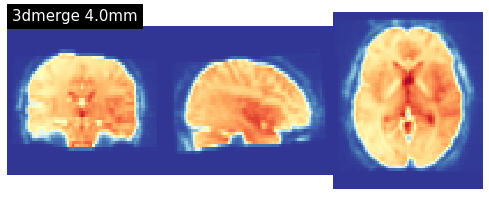

In [9]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(merge_fn, t),
                  cut_coords=coords,
                  title=f'3dmerge {width}mm',
                  cmap="RdYlBu_r", black_bg=False,
                  draw_cross=False, annotate=False);

### Smoothing with `3dBlurInMask`
Next, we smooth the data using the newer program [`3dBlurInMask`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurInMask.html). This program iteratively applies the specified smoothness to the data and allows us to specify a mask to constrain smoothing. In this case, we'll apply smoothing with width 5.0 mm FWHM.

In [10]:
# Try 3dBlurInMask smoothing with mask
width = 5.0
blurinmask_fn = (f'{subject}_task-{task}_space-MNI152NLin2009cAsym'
                 f'_desc-3dBlurInMask{width}_bold.nii.gz')

run(f"3dBlurInMask -FWHM {width} -mask {mask_fn} "
    f"-input {bold_fn} -prefix {blurinmask_fn}", shell=True);

#### Evaluating smoothness after `3dBlurInMask`
Again, we use `3dFWHMx` to assess the resulting smoothness of the data after applying `3dBlurInMask`. When we visualizae the smoothness, we can see the impact of constraining the smoothing algorithm with a whole-brain mask. For this example dataset, applying a 5.0 mm FWHM Gaussian kernel wiith `3dmerge` results in a smoothness of 6.081 mm FHWM.

In [11]:
# Check FWHM after 3dBlurInMask
blurinmask_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {blurinmask_fn} "
                      "-detrend -acf NULL -ShowMeClassicFWHM",
                      shell=True, stdout=PIPE)
print(f"FWHM (after 3dBlurInMask with {width} mm kernel):\n",
      blurinmask_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (after 3dBlurInMask with 5.0 mm kernel):
  5.86561  6.09081  6.29519     6.08134


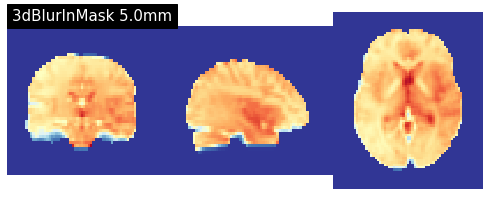

In [12]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(blurinmask_fn, t),
                  cut_coords=coords,
                  title=f'3dBlurInMask {width}mm',
                  cmap="RdYlBu_r", black_bg=False,
                  draw_cross=False, annotate=False);

### Smoothing with `3dBlurToFWHM`
Finally, we use [`3dBlurToFWHM`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dBlurToFWHM.html) to spatially smooth the data. Unlike `3dmerge` and `3dBlurInMask`, rather than globally introducing a fixed amount of smoothness into the data, `3dBlurToFWHM` iteratively smooths the data until a desired smoothness is reached (in all dimensions). At each iteration, both local and global smoothness are estimated; unsmooth parts of the image are locally smoothed, while neighborhoods where local smoothness reaches the target smoothness are not further smoothed. When used for cluster-level statistics, `3dBlurToFWHM` should be supplied with a master image (`-blurmaster`) reflecting noise (e.g., the `-errts` output of [`3dDeconvolve`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dDeconvolve.html)); this master dataset is smoothed to a target smoothness, and then the same smoothing schedule is applied to the dataset of interest. For our purposes, we simply duplicate the input dataset as the master dataset and detrend the master dataset when determining the smoothing smoothing schedule (`-detrend`). We specify a target smoothness of 6.0 mm FWHM.

In [13]:
# Try 3dBlurToFWHM with target smoothness
target = 6.0
blurtofwhm_fn = (f'{subject}_task-{task}_space-MNI152NLin2009cAsym'
                 f'_desc-3dBlurToFWHM{target}_bold.nii.gz')

run(f"3dBlurToFWHM -mask {mask_fn} -FWHM {target} "
    f"-input {bold_fn} -prefix {blurtofwhm_fn} "
    f"-blurmaster {bold_fn} -detrend", shell=True);

#### Evaluating smoothness after `3dBlurToFWHM`
We can use `3dFWHMx` to confirm that `3dBlurToFWHM` achieved the target smoothness and visualize the result. For this example dataset, using `3dBlurToFWHM` with a target smoothness of 6.0 mm FWHM resulted in a smoothness of 5.951 mm FWHM (as expected).

In [14]:
# Check FWHM after 3dBlurToFWHM (should roughly match)
blurtofwhm_fwhm = run(f"3dFWHMx -mask {mask_fn} -input {blurtofwhm_fn} "
                      "-detrend -acf NULL -ShowMeClassicFWHM",
                      shell=True, stdout=PIPE)
print(f"FWHM (after 3dBlurToFWHM with {target} mm target smoothness):\n",
      blurtofwhm_fwhm.stdout.decode('utf-8').partition('\n')[0])

FWHM (after 3dBlurToFWHM with 6.0 mm target smoothness):
  5.7487  5.81199  6.30655     5.95062


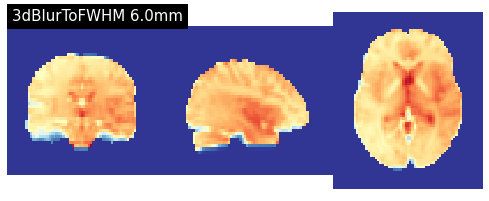

In [15]:
# Plot midpoint TR of EPI to visualize smoothness
coords, t = (40, -20, 0), n_trs // 2
plotting.plot_epi(image.index_img(blurtofwhm_fn, t),
                  cut_coords=coords,
                  title=f'3dBlurToFWHM {target}mm',
                  cmap="RdYlBu_r", black_bg=False,
                  draw_cross=False, annotate=False);

These analyses suggest that 4.0 mm FWHM smoothing with `3dmerge` and 5.0 mm FWHM smoothing with `3dBlurInMask` yield a smoothness of 6.0 mm FWHM, which can also be achieved using `3dBlurToFWHM` with a 6.0 mm FWHM target smoothness. Using `3dBlurToFWHM` has the benefit of allowing us to standardize smoothness across different datasets with different intrinsic smoothness, an important element of data harmonization ([Friedman et al., 2006](https://doi.org/10.1016/j.neuroimage.2006.03.062)).

## Surface-based smoothing
In the following, we evaluate two variations of surface-based smoothing using AFNI's surface-analysis suite [SUMA](https://afni.nimh.nih.gov/Suma). These analyses rely on [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) 2D reconstructions of the cortical sheet ([Dale et al., 1999](https://doi.org/10.1006/nimg.1998.0395); [Fischl, 2012](https://doi.org/10.1016/j.neuroimage.2012.01.021)). Although surface-based analysis typically requires an additional interpolation or resampling step, there is considerable evidence that for superior intersubject alignment (e.g., [Fischl et al., 1999](https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C272::AID-HBM10%3E3.0.CO;2-4); [Argall et al., 2006](https://doi.org/10.1002/hbm.20158)), smoothing (e.g., [Jo et al., 2007](https://doi.org/10.1016/j.neuroimage.2006.09.047), [Anticevic et al., 2008](https://doi.org/10.1016/j.neuroimage.2008.02.052)), and localization (e.g., [Jo et al., 2008](https://doi.org/10.1016/j.neuroimage.2007.12.036), [Coalson et al., 2018](https://doi.org/10.1073/pnas.1801582115)).

### Example surface data
We use the same functional run from the Narratives collection ([Nastase et al., 2019](https://doi.org/10.18112/openneuro.ds002345.v1.0.1)) projected onto the surface using [fMRIPrep](https://fmriprep.readthedocs.io/en/stable/) ([Esteban et al., 2019](https://doi.org/10.1038/s41592-018-0235-4)). This subject has been spatially normalized to a downsampled version of the [fsaverage](https://surfer.nmr.mgh.harvard.edu/fswiki/FsAverage) template (`fsaverage6`). We confine ourselves to the left hemisphere for simplicity and use FreeSurfer's representation of the pial surface (`lh.pial`) to guide surface-based smoothing; a mask is not required because the analysis is already constrained to the cortical surface.

In [16]:
# Set parameters for surface-based smoothing
subject = 'sub-050'
task = 'pieman'
hemi = 'L'
surf = 'lh.pial'

bold_fn = f'{subject}_task-{task}_space-fsaverage6_hemi-{hemi}.func.gii'

### Evaluating the intrinsic smoothness of the surface data
We can estimate the intrinsic smoothness of the surface data using SUMA's [`SurfFWHM`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/SurfFWHM.html) and visualize the smoothness using `nilearn`'s `plot_surf_stat_map`. We use the pial surface to guide smoothing (`-i_fs`) and detrend the time series data when estimating smoothness (`-detrend`). For this example surface dataset, the intrinsic smoothness is 3.819 mm FWHM.

In [17]:
# Estimate FWHM of original data on surface
surf_fwhm = run(f"SurfFWHM -input {bold_fn} -detrend "
                f"-i_fs {surf}", shell=True, stdout=PIPE)
print("FWHM (native surface):",
      surf_fwhm.stdout.decode('utf-8').strip().split(
          '\n')[-1].split('= ')[-1])

FWHM (native surface): 3.8194


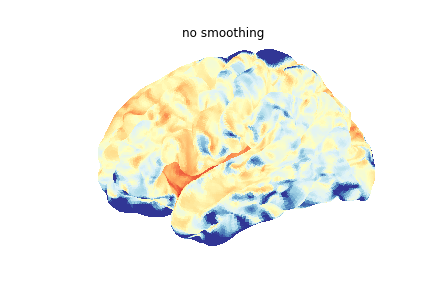

In [18]:
# Plot midpoint TR of BOLD to visualize smoothness
t = n_trs // 2
sulc_fn = 'lh.sulc'
view = 'lateral'
surf_data = nib.load(bold_fn).agg_data()[:, t]
surf_norm = ((surf_data - np.nanmean(surf_data, axis=0)) / 
             np.nanstd(surf_data, axis=0))
plotting.plot_surf_stat_map(surf, surf_norm, view=view, vmax=2,
                            hemi='left', cmap="RdYlBu_r",
                            colorbar=False, bg_map=sulc_fn,
                            title='no smoothing');

### Smoothing with `SurfSmooth`'s Gaussian filter
SUMA's [`SurfSmooth`](https://afni.nimh.nih.gov/pub/dist/doc/program_help/SurfSmooth.html) allows us to smooth the data with a Gaussian filter of a specified width (`-fwhm`), similarly to `3dmerge` or `3dBlurInMask` in volume space. Here, we spatially smooth the data with a 4.0 mm FWHM Gaussian filter.

In [19]:
# Try SurfSmooth with Gaussian smoothing filter
width = 4.0
surfsmooth_fn = (f'{subject}_task-{task}_space-fsaverage6'
                 f'_hemi-{hemi}_desc-SurfSmooth{width}.func.gii')

run(f"SurfSmooth -input {bold_fn} -fwhm {width} "
    f"-i_fs {surf} -output {surfsmooth_fn} "
    f"-blurmaster {bold_fn} -detrend_master "
    "-met HEAT_07", shell=True);

#### Evaluating smoothness after applying `SurfSmooth` filter
We use `SurfFWHM` to assess the resulting smoothness of the sufrace data after applying a Gaussian smoothing filter using `SurfSmooth`. `SurfSmooth` uses heat kernel smoothing to iteratively smooth the surface data ([Chung et al., 2005](https://doi.org/10.1016/j.neuroimage.2004.12.052); [Hagler et al., 2006](https://doi.org/10.1016/j.neuroimage.2006.07.036)). For this example surface dataset, applying a 4.0 mm FWHM Gaussian filter wiith `SurfSmooth` results in a smoothness of 5.635 mm FHWM (a 5.0 mm FWHM filter results in a smoothness of 6.478 mm FWHM).

In [20]:
# Check FWHM after SurfSmooth
surfsmooth_fwhm = run(f"SurfFWHM -input {surfsmooth_fn} -detrend "
                      f"-i_fs {surf}", shell=True, stdout=PIPE)
print(f"FWHM (after SurfSmooth with {width} mm kernel):",
      surfsmooth_fwhm.stdout.decode('utf-8').strip().split(
          '\n')[-1].split('= ')[-1])

FWHM (after SurfSmooth with 4.0 mm kernel): 5.6353


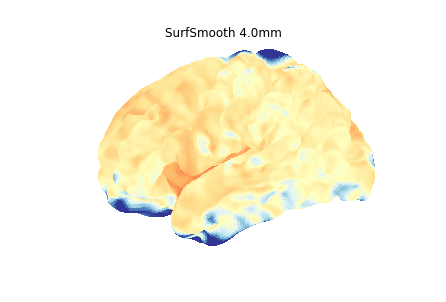

In [21]:
# Plot midpoint TR of BOLD to visualize smoothness
t = n_trs // 2
sulc_fn = 'lh.sulc'
view = 'lateral'
surf_data = np.column_stack(nib.load(surfsmooth_fn).agg_data())[:, t]
surf_norm = ((surf_data - np.nanmean(surf_data, axis=0)) / 
             np.nanstd(surf_data, axis=0))
plotting.plot_surf_stat_map(surf, surf_norm, view=view, vmax=2,
                            hemi='left', cmap="RdYlBu_r",
                            colorbar=False, bg_map=sulc_fn,
                            title=f'SurfSmooth {width}mm');

### Smoothing with `SurfSmooth`'s target smoothness
Similarly to `3dBlurToFWHM`, we can also use `SurfSmooth` to iteratively apply local smoothing the surface data until a target global smoothness is reached (`-target_fwhm`). Here we specify a target global smoothness of 6.0 mm FWHM.

In [22]:
# Try SurfSmooth with 6 mm target smoothness
target = 6.0
targetsmooth_fn = (f'{subject}_task-{task}_space-fsaverage6'
                 f'_hemi-{hemi}_desc-SurfSmoothT{target}.func.gii')

run(f"SurfSmooth -input {bold_fn} -target_fwhm {target} "
    f"-i_fs {surf} -output {targetsmooth_fn} "
    f"-blurmaster {bold_fn} -detrend_master "
    "-met HEAT_07", shell=True);

#### Evaluating target smoothness after `SurfSmooth`
We can use `SurfFWHM` to confirm that `SurfSmooth` achieved the target smoothness and visualize the result. For this example dataset, using `3dBlurToFWHM` with a target smoothness of 6.0 mm FWHM resulted in a smoothness of 6.399 mm FWHM (as expected, with some discrepancy).

In [23]:
# Check FWHM after SurfSmooth with target smoothness (should match)
targetsmooth_fwhm = run(f"SurfFWHM -input {targetsmooth_fn} -detrend "
                        f"-i_fs {surf}", shell=True, stdout=PIPE)
print(f"FWHM (after SurfSmooth with {target} mm kernel):",
      targetsmooth_fwhm.stdout.decode('utf-8').strip().split(
          '\n')[-1].split('= ')[-1])

FWHM (after SurfSmooth with 6.0 mm kernel): 6.3986


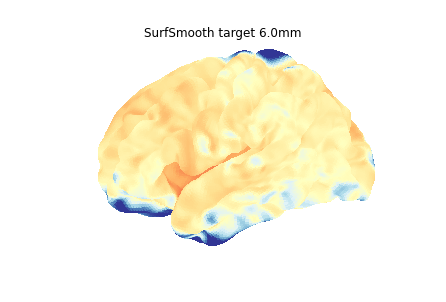

In [24]:
# Plot midpoint TR of BOLD to visualize smoothness
t = n_trs // 2
sulc_fn = 'lh.sulc'
view = 'lateral'
surf_data = np.column_stack(nib.load(targetsmooth_fn).agg_data())[:, t]
surf_norm = ((surf_data - np.nanmean(surf_data, axis=0)) / 
             np.nanstd(surf_data, axis=0))
plotting.plot_surf_stat_map(surf, surf_norm, view=view, vmax=2,
                            hemi='left', cmap="RdYlBu_r",
                            colorbar=False, bg_map=sulc_fn,
                            title=f'SurfSmooth target {target}mm');

## Conclusion
In summary, these analyses demonstrate how we can use either `3dBlurToFWHM` or `SurfSmooth` to achieve a desired level of smoothness, and how this can be related to more conventional smoothing methods (e.g., `3dmerge`, `3dBlurInMask`). For this example dataset, using `3dBlurToFWHM` or `SurfSmooth` to reach a target smoothness of 6.0 mm FWHM is similar to smoothing the data with a ~4.0–5.0 mm FWHM Gaussian kernel. For applications that require aggregating across heterogeneous datasets, we recommend using `3dBlurToFWHM` or `SurfSmooth` for harmonizing the smoothness of the datasets.

## References
* Anticevic, A., Dierker, D. L., Gillespie, S. K., Repovs, G., Csernansky, J. G., Van Essen, D. C., & Barch, D. M. (2008). Comparing surface-based and volume-based analyses of functional neuroimaging data in patients with schizophrenia. *NeuroImage*, *41*(3), 835-848.  
https://doi.org/10.1016/j.neuroimage.2008.02.052

* Argall, B. D., Saad, Z. S., & Beauchamp, M. S. (2006). Simplified intersubject averaging on the cortical surface using SUMA. *Human Brain Mapping*, *27*(1), 14-27.  
https://doi.org/10.1002/hbm.20158

* Chung, M. K., Robbins, S. M., Dalton, K. M., Davidson, R. J., Alexander, A. L., & Evans, A. C. (2005). Cortical thickness analysis in autism with heat kernel smoothing. *NeuroImage*, *25*(4), 1256-1265.  
https://doi.org/10.1016/j.neuroimage.2004.12.052

* Coalson, T. S., Van Essen, D. C., & Glasser, M. F. (2018). The impact of traditional neuroimaging methods on the spatial localization of cortical areas. *Proceedings of the National Academy of Sciences of the United States of America*, *115*(27), E6356-E6365.  
https://doi.org/10.1073/pnas.1801582115

* Cox, R. W. (1996). AFNI: software for analysis and visualization of functional magnetic resonance neuroimages. *Computers and Biomedical Research*, *29*(3), 162-173.  
https://doi.org/10.1006/cbmr.1996.0014

* Cox, R. W. (2012). AFNI: what a long strange trip it's been. *NeuroImage*, *62*(2), 743-747.  
https://doi.org/10.1016/j.neuroimage.2011.08.056

* Dale, A. M., Fischl, B., & Sereno, M. I. (1999). Cortical surface-based analysis: I. segmentation and surface reconstruction. *NeuroImage*, *9*(2), 179-194.  
https://doi.org/10.1006/nimg.1998.0395

* Esteban, O., Markiewicz, C., Blair, R. W., Moodie, C., Isik, A. I., Erramuzpe, A., Kent, J. D., Goncalves, M., DuPre, E., Snyder, M., Oya, H., Ghosh, S., Wright, J., Durnez, J., Poldrack, R., & Gorgolewski, K. J. (2019). fMRIPrep: a robust preprocessing pipeline for functional MRI. *Nature Methods*, *16*, 111-116.  
https://doi.org/10.1038/s41592-018-0235-4

* Forman, S. D., Cohen, J. D., Fitzgerald, M., Eddy, W. F., Mintun, M. A., & Noll, D. C. (1995). Improved assessment of significant activation in functional magnetic resonance imaging (fMRI): use of a cluster‐size threshold. *Magnetic Resonance in Medicine*, *33*(5), 636-647.  
https://doi.org/10.1002/mrm.1910330508

* Fischl, B. (2012). FreeSurfer. *NeuroImage*, *62*(2), 774-781.  
https://doi.org/10.1016/j.neuroimage.2012.01.021

* Fischl, B., Sereno, M. I., Tootell, R. B., & Dale, A. M. (1999). High‐resolution intersubject averaging and a coordinate system for the cortical surface. *Human Brain Mapping*, *8*(4), 272-284.  
https://doi.org/10.1002/(SICI)1097-0193(1999)8:4%3C272::AID-HBM10%3E3.0.CO;2-4

* Friedman, L., Glover, G. H., Krenz, D., Magnotta, V., & The FIRST BIRN (2006). Reducing inter-scanner variability of activation in a multicenter fMRI study: role of smoothness equalization. *NeuroImage*, *32*(4), 1656-1668.  
https://doi.org/10.1016/j.neuroimage.2006.03.062

* Hagler Jr, D. J., Saygin, A. P., & Sereno, M. I. (2006). Smoothing and cluster thresholding for cortical surface-based group analysis of fMRI data. *NeuroImage*, *33*(4), 1093-1103.  
https://doi.org/10.1016/j.neuroimage.2006.07.036

* Jo, H. J., Lee, J. M., Kim, J. H., Choi, C. H., Gu, B. M., Kang, D. H., Ku, J., Kwon, J. S., & Kim, S. I. (2008). Artificial shifting of fMRI activation localized by volume-and surface-based analyses. *NeuroImage*, *40*(3), 1077-1089.  
https://doi.org/10.1016/j.neuroimage.2007.12.036

* Jo, H. J., Lee, J. M., Kim, J. H., Shin, Y. W., Kim, I. Y., Kwon, J. S., & Kim, S. I. (2007). Spatial accuracy of fMRI activation influenced by volume-and surface-based spatial smoothing techniques. *NeuroImage*, *34*(2), 550-564.  
https://doi.org/10.1016/j.neuroimage.2006.09.047

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C. B., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2019). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *OpenNeuro*, ds002345.  
https://doi.org/10.18112/openneuro.ds002345.v1.0.1

* Saad, Z. S., & Reynolds, R. C. (2012). SUMA. *NeuroImage*, *62*(2), 768-773.  
https://doi.org/10.1016/j.neuroimage.2011.09.016

* Saad, Z. S., Reynolds, R. C., Argall, B., Japee, S., & Cox, R. W. (2004). SUMA: an interface for surface-based intra-and inter-subject analysis with AFNI. In *2nd IEEE International Symposium on Biomedical Imaging: Nano to Macro* (pp. 1510-1513). IEEE.  
https://doi.org/10.1109/ISBI.2004.1398837